# Quantitative analysis of the binaries in the Horizontal Branch

### Import all the files
First import and filter the data, then import the binary systems that we have built before. 

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.widgets import PolygonSelector, Button
from matplotlib.path import Path
import csv

%matplotlib widget

In [2]:
import sys
import os

# set the path to the tools folder
module_path = '/Users/giadaaggio/Desktop/Thesis/TOTORO/CODES/tools'
sys.path.append(module_path)

from binaries_utils import BinaryStarUtils
binary = BinaryStarUtils()

Initialize the colormap

In [3]:
colormap = plt.cm.jet

In [4]:
# load and clean data
input_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/hlsp_hugs_hst_wfc3-uvis-acs-wfc_ngc0104_multi_v1_catalog-meth1.txt'
df = pd.read_csv(input_file, header=None, delim_whitespace=True, 
                   usecols=[0, 1, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32], 
                   names=['X','Y','F275W','rad_275','F336W','rad_336','F435W','rad_435','F606W','rad_606','F814W','rad_814','prob_member'], skiprows=55)

df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()

In [5]:
# flag the data that are ok (membership probability and radxs)
# set the conditions
conditions = (
    (df['prob_member'] >= 90) & 
    (np.abs(df['rad_275']) < 0.05) &
    (np.abs(df['rad_336']) < 0.05) &
    (np.abs(df['rad_435']) < 0.05) &
    (np.abs(df['rad_606']) < 0.05) &
    (np.abs(df['rad_814']) < 0.05) 
    )   

# assign the flag 
df['flag'] = np.where(conditions, 1, 0)

In [6]:
# select the data with flag 1 
data = df[df['flag'] == 1]

In [7]:
primary_stars = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/primary_stars.csv', delim_whitespace=True)
primary_stars['index'] = primary_stars.index
color_test = colors = binary.color_index(primary_stars, 'index', colormap)

BS_HB_vis = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_HB_vis.csv', delim_whitespace=True, skiprows=2)
BS_HB_uv = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/BS_HB_uv.csv', delim_whitespace=True, skiprows=2)

color_vis = binary.color_index(BS_HB_vis, 'secondary', colormap)
color_uv = binary.color_index(BS_HB_uv, 'secondary', colormap)

Plot the CMD with the built binaries

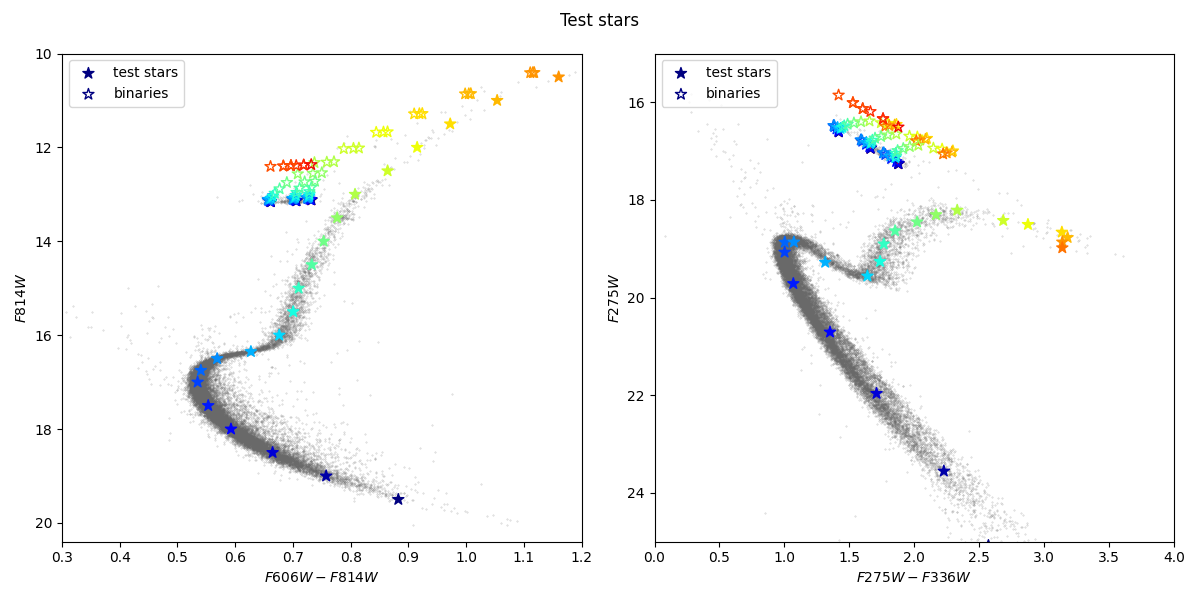

In [8]:
plt.figure(figsize=(12, 6))

# plot optical filters
plt.subplot(1, 2, 1)

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(primary_stars['F606W']-primary_stars['F814W'], primary_stars['F814W'], s=70, c=colors, label='test stars', marker='*', zorder=2)
plt.scatter(BS_HB_vis['F606W']-BS_HB_vis['F814W'], BS_HB_vis['F814W'], s=70, edgecolor=color_vis, facecolors='none', label='binaries', marker='*', zorder=3)
plt.gca().invert_yaxis()

plt.xlim(0.3,1.2)
plt.ylim(20.4,10)

plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='upper left')

# plot UV filters
plt.subplot(1, 2, 2)

plt.scatter(data['F275W']-data['F336W'], data['F275W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(primary_stars['F275W']-primary_stars['F336W'], primary_stars['F275W'], s=70, c=colors, label='test stars', marker='*', zorder=2)
plt.scatter(BS_HB_uv['F275W']-BS_HB_uv['F336W'], BS_HB_uv['F275W'], s=70, edgecolor=color_uv, facecolors='none', label='binaries', marker='*', zorder=3)
plt.gca().invert_yaxis()

plt.xlim(0,4)
plt.ylim(25, 15)

plt.xlabel(r'$F275W-F336W$')
plt.ylabel(r'$F275W$')
plt.legend(loc='upper left')

plt.suptitle('Test stars')
plt.tight_layout()
plt.show()

## Quantitative analysis binaries (HB)
We have to make an estimate of the fraction of binaries in the region over the horizontal branch. To do so we have to select a region where the binaries are, comprehensive of the HB, then I have to select a second region containing only the binaries.

I have to count both the stars in the total region and the ones in the binaries region. I have to discriminate between the HB-HB binaries and the HB-RGB binaries using the ratio q. 
I have to select the region in both CMD, to define its limit use the same secondary star in both CMDs. 

Let's print the binary system built using the HB star with magnitude in F814W of 13.14 (index 23) and the secondary star with magnitude in F814W of 13 (index 15).

In [9]:
# Do you need to select the stars?
region_selection = False

In [10]:
bound_bin_vis_high = BS_HB_vis[(BS_HB_vis['primary'] == 23) & (BS_HB_vis['secondary'] == 15)]
bound_bin_vis_low = BS_HB_vis[(BS_HB_vis['primary'] == 23) & (BS_HB_vis['secondary'] == 11)]
bound_bin_uv_high = BS_HB_uv[(BS_HB_uv['primary'] == 23) & (BS_HB_uv['secondary'] == 15)]
bound_bin_uv_low = BS_HB_uv[(BS_HB_uv['primary'] == 23) & (BS_HB_uv['secondary'] == 11)]

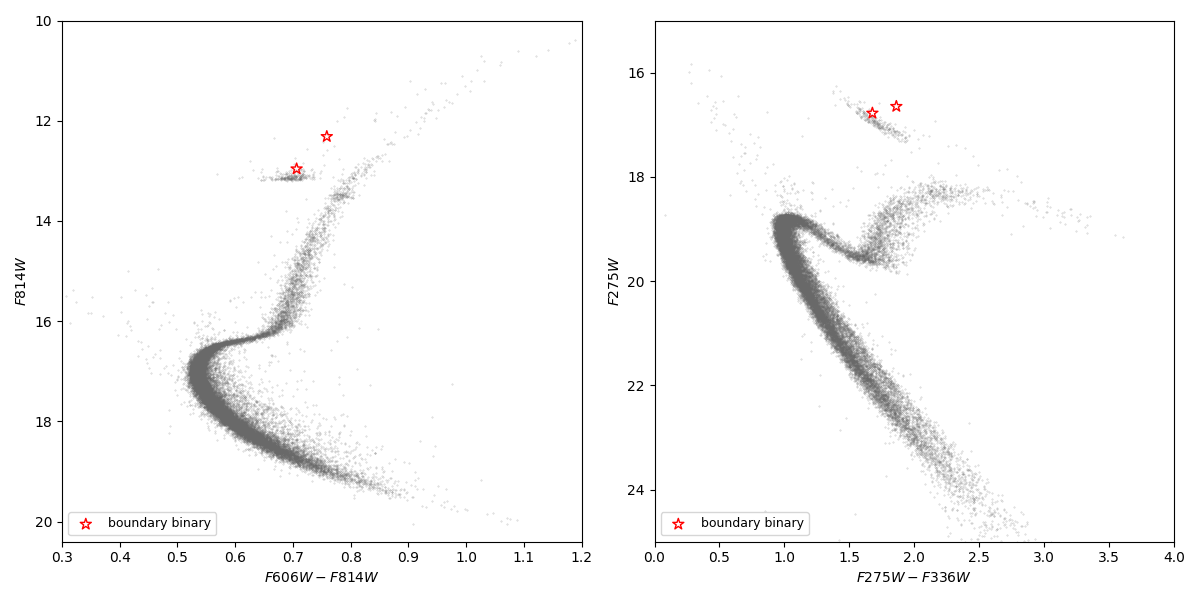

In [11]:
plt.figure(figsize=(12, 6))

# plot optical filters
plt.subplot(1, 2, 1)

plt.scatter(data['F606W']-data['F814W'], data['F814W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(bound_bin_vis_high['F606W']-bound_bin_vis_high['F814W'], bound_bin_vis_high['F814W'], s=70, edgecolor='red', facecolors='none', label='boundary binary', marker='*', zorder=3)
plt.scatter(bound_bin_vis_low['F606W']-bound_bin_vis_low['F814W'], bound_bin_vis_low['F814W'], s=70, edgecolor='red', facecolors='none', marker='*', zorder=3)
plt.gca().invert_yaxis()

plt.xlim(0.3,1.2)
plt.ylim(20.4,10)

plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='lower left', fontsize=9)

# plot UV filters
plt.subplot(1, 2, 2)

plt.scatter(data['F275W']-data['F336W'], data['F275W'], s=0.1, c='dimgray', alpha=0.4, zorder=1)
plt.scatter(bound_bin_uv_high['F275W']-bound_bin_uv_high['F336W'], bound_bin_uv_high['F275W'], s=70, edgecolor='red', facecolors='none', label='boundary binary', marker='*', zorder=3)
plt.scatter(bound_bin_uv_low['F275W']-bound_bin_uv_low['F336W'], bound_bin_uv_low['F275W'], s=70, edgecolor='red', facecolors='none', marker='*', zorder=3)
plt.gca().invert_yaxis()

plt.xlim(0,4)
plt.ylim(25, 15)

plt.xlabel(r'$F275W-F336W$')
plt.ylabel(r'$F275W$')
plt.legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.show()

### Optical CMD
Now that we have set the same boundary in both the CMDs we can start selecting the regions where we need to compute the number of stars to determine the fraction of binaries in the region over the horizontal branch.

In [12]:
from CMDAnalyzer import CMDRegionSelector

In [13]:
if region_selection is True:
    cmd_select_vis = CMDRegionSelector(
        data = data,
        color = data['F606W'] - data['F814W'],
        magnitude = data['F814W'],
        color_bound_bin_high = bound_bin_vis_high['F606W'] - bound_bin_vis_high['F814W'],
        magnitude_bound_bin_high = bound_bin_vis_high['F814W'],
        color_bound_bin_low = bound_bin_vis_low['F606W'] - bound_bin_vis_low['F814W'],
        magnitude_bound_bin_low = bound_bin_vis_low['F814W'],
        x_label='F606W-F814W',
        y_label='F814W',
        output_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_HB_F606W_F814W.csv'
    )

In [14]:
region_vis = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_HB_F606W_F814W.csv')

region_vis_A = CMDRegionSelector.get_stars_inside_region(
    region_id = 0,
    data = data, 
    color = data['F606W']-data['F814W'], 
    magnitude = data['F814W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_HB_F606W_F814W.csv')

region_vis_B = CMDRegionSelector.get_stars_inside_region(
    region_id = 1,
    data = data, 
    color = data['F606W']-data['F814W'], 
    magnitude = data['F814W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_HB_F606W_F814W.csv')

print('Stars in Region A:', len(region_vis_A))
print('Stars in Region B:', len(region_vis_B))

frac_HB_bin_vis = len(region_vis_B) / (len(region_vis_A) + len(region_vis_B))
print('Binary fraction:', frac_HB_bin_vis)

Stars in Region A: 241
Stars in Region B: 15
Binary fraction: 0.05859375


In [15]:
region_names = {
    0: 'Region A',
    1: 'Region B',
}

region_colors = {
    0: 'red',
    1: 'blue',
}

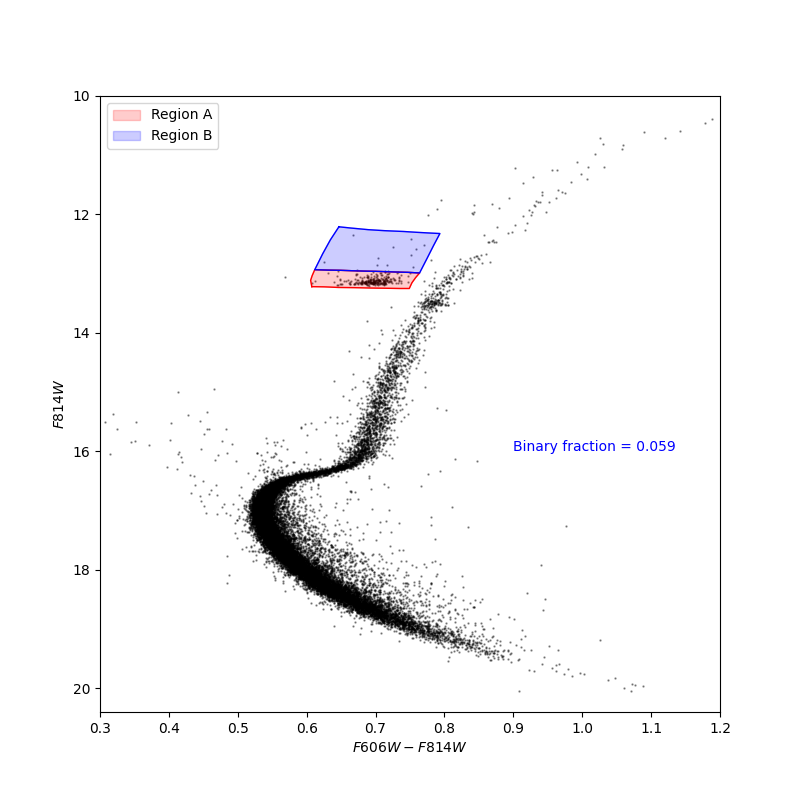

In [16]:
# Plot the CMD
fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(data['F606W'] - data['F814W'], data['F814W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax.invert_yaxis()
ax.set_xlim(0.3, 1.2)
ax.set_ylim(20.4, 10)
ax.set_xlabel(r'$F606W-F814W$')
ax.set_ylabel(r'$F814W$')

# Group by Region_ID and plot each region
for region_id, region in region_vis.groupby("Region_ID"):
    # Append the first point to close the polygon
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")  # Default to "Region X"

    # Fill the inside of the region
    ax.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)

    # Plot the region outline
    ax.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

# Add text to the plot using the value of the variable
ax.text(0.9, 16, f'Binary fraction = {frac_HB_bin_vis:.3f}', fontsize=10, color='blue')

ax.legend()
plt.show()

### UV CMD

In [17]:
if region_selection is True:
    cmd_select_uv = CMDRegionSelector(
        data = data,
        color = data['F275W'] - data['F336W'],
        magnitude = data['F275W'],
        color_bound_bin_high = bound_bin_uv_high['F275W'] - bound_bin_uv_high['F336W'],
        magnitude_bound_bin_high = bound_bin_uv_high['F275W'],
        color_bound_bin_low = bound_bin_uv_low['F275W'] - bound_bin_uv_low['F336W'],
        magnitude_bound_bin_low = bound_bin_uv_low['F275W'],
        x_label='F275W-F336W',
        y_label='F275W',
        output_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_HB_F275W_F336W.csv'
    )

In [18]:
region_uv = pd.read_csv('/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_HB_F275W_F336W.csv')

region_uv_A = CMDRegionSelector.get_stars_inside_region(
    region_id = 0,
    data = data, 
    color = data['F275W']-data['F336W'], 
    magnitude = data['F275W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_HB_F275W_F336W.csv')

region_uv_B = CMDRegionSelector.get_stars_inside_region(
    region_id = 1,
    data = data, 
    color = data['F275W']-data['F336W'], 
    magnitude = data['F275W'], 
    regions_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/regions_HB_F275W_F336W.csv')

print('Stars in Region A:', len(region_uv_A))
print('Stars in Region B:', len(region_uv_B))

frac_HB_bin_uv = len(region_uv_B) / (len(region_uv_A) + len(region_uv_B))
print('Binary fraction:', frac_HB_bin_uv)

Stars in Region A: 238
Stars in Region B: 11
Binary fraction: 0.04417670682730924


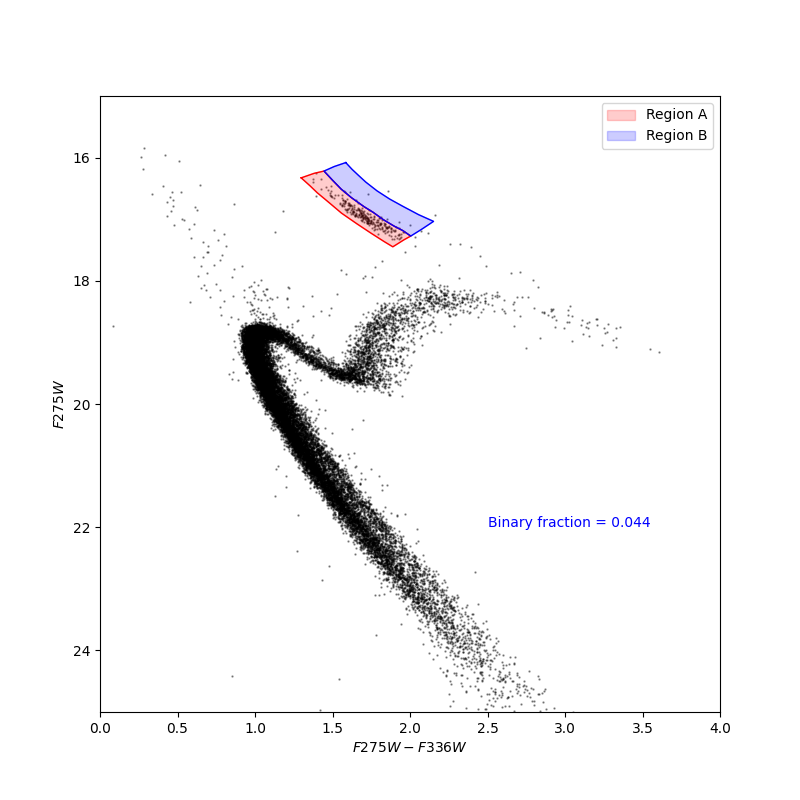

In [19]:
# Plot the CMD
fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(data['F275W'] - data['F336W'], data['F275W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax.invert_yaxis()
ax.set_xlim(0, 4)
ax.set_ylim(25, 15)
ax.set_xlabel(r'$F275W-F336W$')
ax.set_ylabel(r'$F275W$')

# Group by Region_ID and plot each region
for region_id, region in region_uv.groupby("Region_ID"):
    # Append the first point to close the polygon
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")  # Default to "Region X"

    # Fill the inside of the region
    ax.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)

    # Plot the region outline
    ax.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

# Add text to the plot using the value of the variable
ax.text(2.5, 22, f'Binary fraction = {frac_HB_bin_uv:.3f}', fontsize=10, color='blue')

ax.legend()
plt.show()

Since I am getting two different fractions for the UV and the optical CMD I need to use the UV CMD to discriminate between possible binary systems and AGB stars. To do so I can do a cutoff in color in the UV cmd and then use it to select the stars in the optical one. 

In [20]:
if region_selection is True:
    agb_region_selection = CMDRegionSelector(
        data = data,
        color = data['F275W'] - data['F814W'],
        magnitude = data['F336W'],
        x_label='F275W-F814W',
        y_label='F336W',
        output_file = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/agb_F275W_F336W.csv'
    )

In [21]:
agb_region = '/Users/giadaaggio/Desktop/Thesis/TOTORO/FITS/47_Tuc/agb_F275W_F336W.csv'
agb_stars = CMDRegionSelector.get_stars_inside_region(0, data, data['F275W']-data['F814W'], data['F336W'], agb_region)

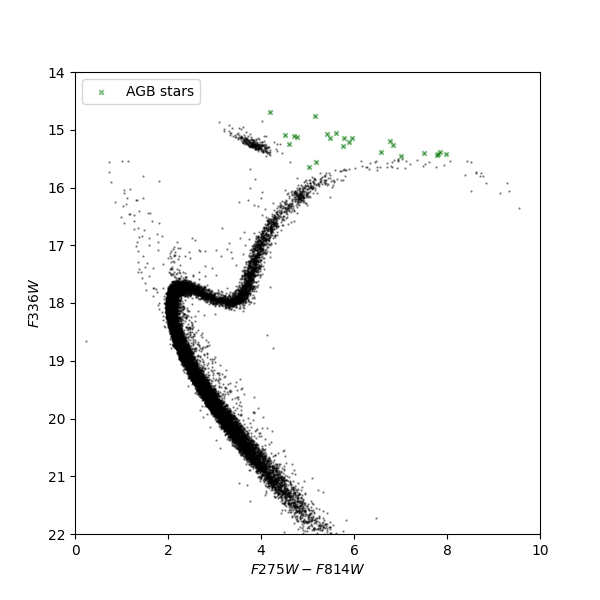

In [22]:
# CMD used to select agb stars
plt.figure(figsize=(6,6))

plt.scatter(data['F275W'] - data['F814W'], data['F336W'], s=0.5, c='black', alpha=0.4, zorder=1)
plt.scatter(agb_stars['F275W'] - agb_stars['F814W'], agb_stars['F336W'], s=10, c='green', alpha=0.5, zorder=2, marker='x', label='AGB stars')
plt.gca().invert_yaxis()
plt.xlim(0, 10)
plt.ylim(22, 14)
plt.xlabel(r'$F275W-F814W$')
plt.ylabel(r'$F336W$')
plt.legend(loc='upper left')

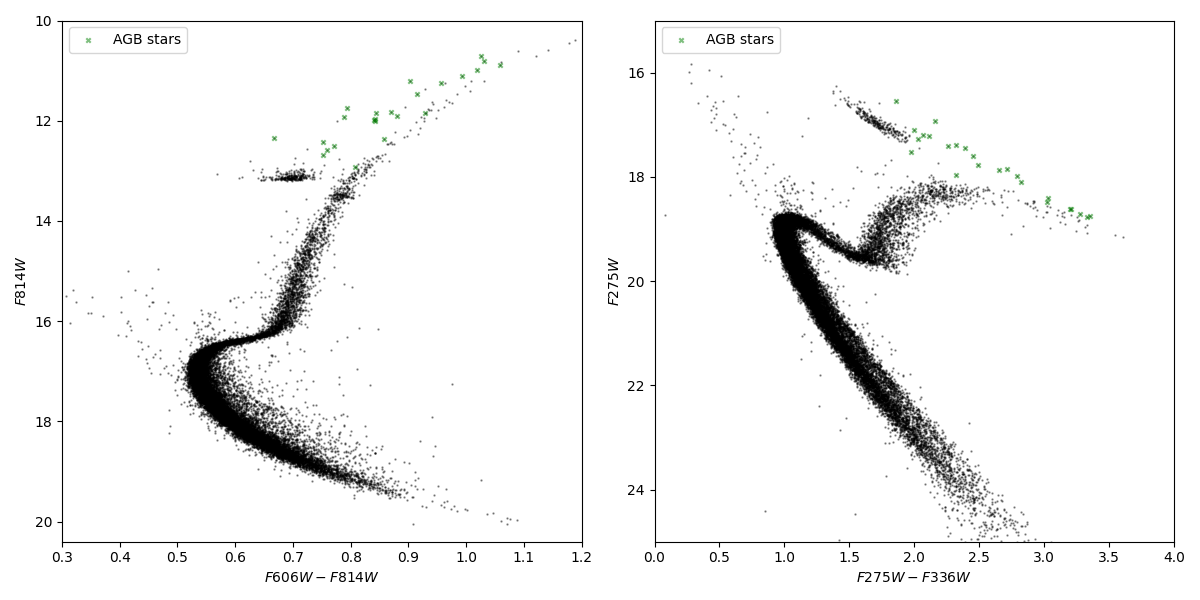

In [23]:
# highlight the AGB stars in the visible CMD
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data['F606W'] - data['F814W'], data['F814W'], s=0.5, c='black', alpha=0.4, zorder=1)
plt.scatter(agb_stars['F606W'] - agb_stars['F814W'], agb_stars['F814W'], s=10, c='green', alpha=0.5, zorder=2, marker='x', label='AGB stars')
plt.gca().invert_yaxis()
plt.xlim(0.3, 1.2)
plt.ylim(20.4, 10)
plt.xlabel(r'$F606W-F814W$')
plt.ylabel(r'$F814W$')
plt.legend(loc='upper left')

# highlight the AGB stars in the UV CMD
plt.subplot(1, 2, 2)
plt.scatter(data['F275W'] - data['F336W'], data['F275W'], s=0.5, c='black', alpha=0.4, zorder=1)
plt.scatter(agb_stars['F275W'] - agb_stars['F336W'], agb_stars['F275W'], s=10, c='green', alpha=0.5, zorder=2, marker='x', label='AGB stars')
plt.gca().invert_yaxis()
plt.xlim(0, 4)
plt.ylim(25, 15)
plt.xlabel(r'$F275W-F336W$')
plt.ylabel(r'$F275W$')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


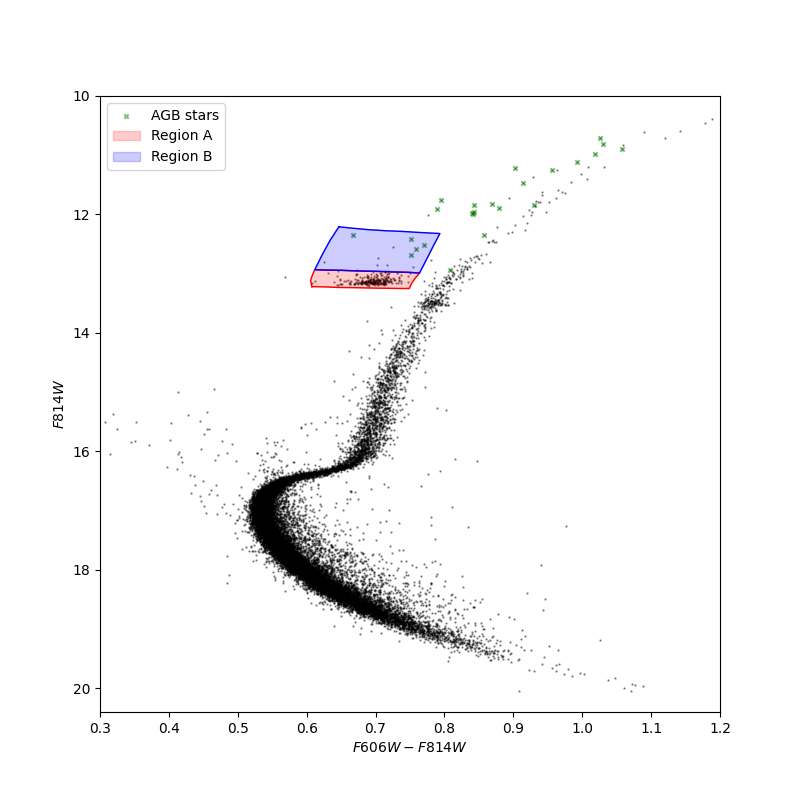

In [24]:
# Plot the CMD
fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(data['F606W'] - data['F814W'], data['F814W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax.scatter(agb_stars['F606W'] - agb_stars['F814W'], agb_stars['F814W'], s=10, c='green', alpha=0.5, zorder=2, marker='x', label='AGB stars')
ax.invert_yaxis()
ax.set_xlim(0.3, 1.2)
ax.set_ylim(20.4, 10)
ax.set_xlabel(r'$F606W-F814W$')
ax.set_ylabel(r'$F814W$')

# Group by Region_ID and plot each region
for region_id, region in region_vis.groupby("Region_ID"):
    # Append the first point to close the polygon
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")  # Default to "Region X"

    # Fill the inside of the region
    ax.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)

    # Plot the region outline
    ax.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

ax.legend()
plt.show()

There are some AGB stars inside the region B, which influence the binary fraction, therefore we need to delete them. 

In [25]:
# recompute the binary fraction in the selected regions without counting the AGB stars
region_vis_B_noagb = region_vis_B[~region_vis_B.index.isin(agb_stars.index)]

frac_HB_bin_vis_noagb = len(region_vis_B_noagb) / (len(region_vis_A) + len(region_vis_B_noagb))
print('Binary fraction (no AGB)')
print('Visible:', frac_HB_bin_vis_noagb)

region_uv_B_noagb = region_uv_B[~region_uv_B.index.isin(agb_stars.index)]

frac_HB_bin_uv_noagb = len(region_uv_B_noagb) / (len(region_uv_A) + len(region_uv_B_noagb))
print('UV:', frac_HB_bin_uv_noagb)

Binary fraction (no AGB)
Visible: 0.0398406374501992
UV: 0.04032258064516129


## Final results


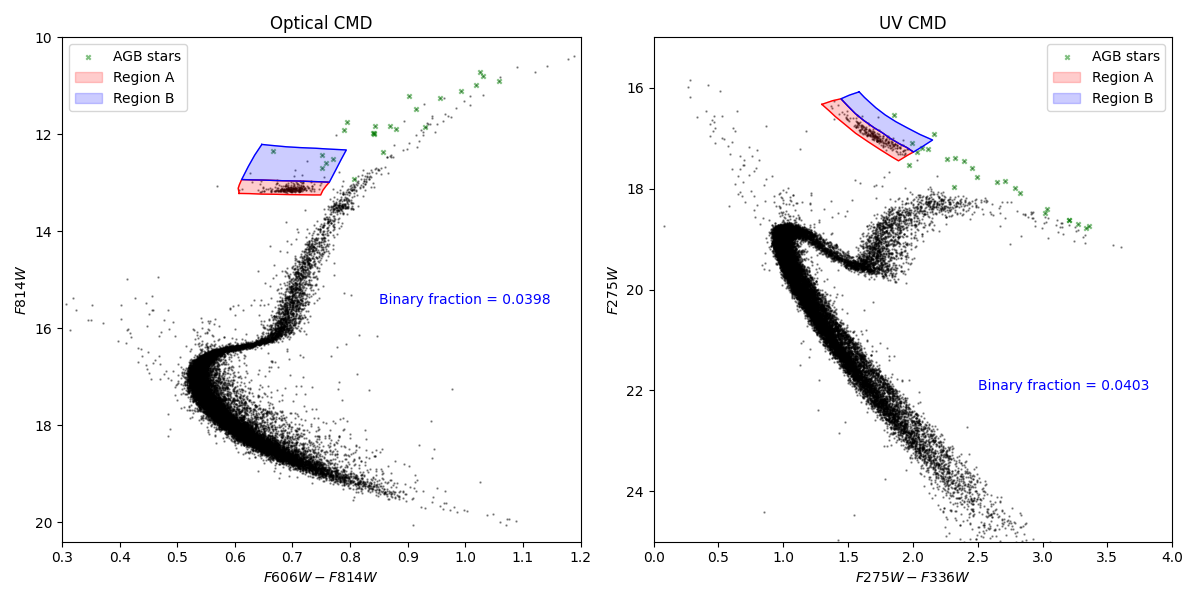

In [26]:
# Create a figure with two subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First CMD plot
ax1 = axes[0]
scatter1 = ax1.scatter(data['F606W'] - data['F814W'], data['F814W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax1.scatter(agb_stars['F606W'] - agb_stars['F814W'], agb_stars['F814W'], s=10, c='green', alpha=0.5, zorder=2, marker='x', label='AGB stars')
ax1.invert_yaxis()
ax1.set_xlim(0.3, 1.2)
ax1.set_ylim(20.4, 10)
ax1.set_xlabel(r'$F606W-F814W$')
ax1.set_ylabel(r'$F814W$')
ax1.set_title("Optical CMD")

# Plot regions for first CMD
for region_id, region in region_vis.groupby("Region_ID"):
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")

    ax1.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)
    ax1.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

# Add text annotation
ax1.text(0.85, 15.5, f'Binary fraction = {frac_HB_bin_vis_noagb:.4f}', fontsize=10, color='blue')
ax1.legend()

# Second CMD plot
ax2 = axes[1]
scatter2 = ax2.scatter(data['F275W'] - data['F336W'], data['F275W'], s=0.5, c='black', alpha=0.4, zorder=1)
ax2.scatter(agb_stars['F275W'] - agb_stars['F336W'], agb_stars['F275W'], s=10, c='green', alpha=0.5, zorder=2, marker='x', label='AGB stars')
ax2.invert_yaxis()
ax2.set_xlim(0, 4)
ax2.set_ylim(25, 15)
ax2.set_xlabel(r'$F275W-F336W$')
ax2.set_ylabel(r'$F275W$')
ax2.set_title("UV CMD")

# Plot regions for second CMD
for region_id, region in region_uv.groupby("Region_ID"):
    closed_region = pd.concat([region, region.iloc[[0]]])
    region_label = region_names.get(region_id, f"Region {region_id}")

    ax2.fill(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), alpha=0.2, label=region_label, zorder=2)
    ax2.plot(closed_region["X"], closed_region["Y"], color=region_colors.get(region_id, "black"), linewidth=1, zorder=3)

# Add text annotation
ax2.text(2.5, 22, f'Binary fraction = {frac_HB_bin_uv_noagb:.4f}', fontsize=10, color='blue')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()
